In [1]:
%matplotlib inline
import flopy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pathlib as pl
import pandas as pd
import sys
import itertools
import geopandas as gpd
import xarray as xr
from osgeo import gdal
import rasterio
import xugrid

In [2]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, extentmax, fig_ext, transparent

- AMPLITUDE OF GROUNDWATER HEADS WITH TIDAL INFLUENCE (COMPARE SIMULATED VS. OBSERVED)
-- https://stackoverflow.com/questions/51298604/calculating-amplitude-from-np-fft
-- LIV WILL GET BACK TO BNB ON THIS
- PRESENT THE RESULTS OF THE SEPTEMBER 2018 STORM


MAP
- COMPARE DTW DURING AVERAGE CONDITIONS VS. STORM CONDITIONS
- MAP OF DFLOW WATER DEPTH DURING AVERAGE CONDITIONS VS. STORM CONDITIONS

COMBINED MAP 
- HAZARD DUE TO SURFACE INUNDATION
- HAZARD DUE TO GW EMERGENCE

CROSS SECTION OF MODFLOW AND DFLOW WATER LEVEL

# Units

In [3]:
units = "mm"
conversion_factor = 1.0
if units == "mm":
    conversion_factor = 25.4
total_key = f"total_{units}"

# Load base MODFLOW base model

In [4]:
base_ws = "../modflow/pj_2018_adjust_CHDA1/base/"
sim = flopy.mf6.MFSimulation.load(sim_ws=base_ws, verbosity_level=0)
gwf = sim.get_model("gwf")
# Number of GHB cells 
nghb = gwf.ghb.stress_period_data.get_dataframe()[0].shape[0]
nchd = gwf.get_package("chd_coast").stress_period_data.get_dataframe()[0].shape[0]

## Model Grid

In [5]:
mg =gwf.modelgrid
mg_gdf = mg.geo_dataframe 
# Area of one cell
area = mg.delr[0]*mg.delc[0]
print(f'Cell area: {mg.delr[0]*mg.delc[0]} {mg.units}^2')
mg_gdf['row_pj'] = [x[0] for x in itertools.product(range(mg.nrow), range(mg.ncol))]
mg_gdf['col_pj']=  [x[1] for x in itertools.product(range(mg.nrow), range(mg.ncol))]
mg_gdf.set_crs(epsg = 4456, inplace=True)
print(mg_gdf.crs)

Cell area: 62500.0 feet^2
EPSG:4456


## Model Cell Elevations

In [6]:
path = pl.Path(base_ws)/'external'
lay_arr = np.array([np.loadtxt(path / 'top.dat')] + [np.loadtxt(file) for file in sorted(path.glob('bot*.dat'))])

## Time and SP

In [7]:
tdis = sim.tdis
mf_startdate = tdis.start_date_time.array
mf_perioddata= tdis.perioddata.array
# calculate date for each stress period
mf_SPdates = [pd.to_datetime(mf_startdate)]
for perlen, nstp, tsmult in mf_perioddata:
    mf_SPdates.append(mf_SPdates[-1] + pd.Timedelta(days = perlen))
# remove the last date because it is extra
mf_SPdates = mf_SPdates[:-1]
# Compute cumulative total times at the end of each stress period
mf_totaltimes= tdis.perioddata.array['perlen'].cumsum()

mf_tdis_df = pd.DataFrame({'Date':mf_SPdates,
                           'SP': list(mf_perioddata),
                           'totim': mf_totaltimes})

## Sim Directories

In [8]:
#sim_dirs_noatm = ['run_NoAtm_01.00H']
sim_dirs= ["run_04.00H","run_02.00H","run_01.00H","run_15.00M"]

In [9]:
sim_path = '../modflow/pj_2018_adjust_CHDA1/MF+DFlow/'

# Coastal Exchange

Figure Settings

In [10]:
ws = pl.Path("figures")
ws.mkdir(exist_ok=True, parents=True)

In [11]:
# Create labels
# ===================
labels = [value.split(sep="_")[1] for value in sim_dirs]

for idx, label in enumerate(labels):
    s = f"{float(label[:5]):>2.0f}" + " " + label[-1]
    if s.endswith(" D"):
        s = s.replace(" D", " Day ")
    elif s.endswith(" H"):
        s = s.replace(" H", " Hour")
    elif s.endswith(" M"):
        s = s.replace(" M", " Min.")
    labels[idx] = s    
labels

[' 4 Hour', ' 2 Hour', ' 1 Hour', '15 Min.']

In [12]:
line_styles = ["-", "--", "-.", ":", (0, (3, 10, 1, 10, 1, 10)), (0, (3, 1, 1, 1, 1, 1))]

In [13]:
colors = [value for key, value in mcolors.TABLEAU_COLORS.items()]

## GHB

### Observation Cells

In [14]:
# GHB Obs Cells
# #=====================================================
obscells_GHB = pd.read_csv(fr"{base_ws}gwf.ghb.obs",skiprows=5, sep=r'  ', names = ['ghb_name','head','cellid'])
obscells_GHB['cellid'] = obscells_GHB['cellid'].str.replace(r'\s+', ',', regex=True)
# Split into new columns
obscells_GHB[['lay', 'row', 'col']] = obscells_GHB['cellid'].str.split(',', expand=True)
obscells_GHB = obscells_GHB.iloc[:-1]
obscells_GHB[['lay', 'row', 'col']] = obscells_GHB[['lay', 'row', 'col']].astype(int)
obscells_GHB[['lay', 'row', 'col']]-=1

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_27892\3791279870.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  obscells_GHB = pd.read_csv(fr"{base_ws}gwf.ghb.obs",skiprows=5, sep=r'  ', names = ['ghb_name','head','cellid'])


### Observation Output

In [15]:
obsdict_GHB = {value: {"ws": pl.Path(f"{sim_path}{value}")} for value in sim_dirs }

for key, value in obsdict_GHB.items():
    obs_path = value["ws"] / "outputs" /"GHB_obs.csv"
    print(obs_path)
    # Load the GHB observations
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    # Calculate the length of each timestep
    df["delt (days)"] = df["totim"].diff()
    # Replace the first rows time step length because it will be nan
    df.loc[df["delt (days)"].isnull(), "delt (days)"] = df["delt (days)"].iloc[1]
    
    # Calculate Volumes of exchange per timestep, and cumualtive volumes
    #--------------------------------------------
    df['ft^3']= 0
    df['ft^3/day']= 0
    df['CUM_ft^3'] =0
    df['ft'] = 0.0
    df['ft/day'] = 0.0
    df['CUM_ft'] = 0.0

    df['CUM_ft^3'] =0
    df['ft'] = 0.0
    # list of GHB observation names
    obs_cols = [c for c in df.columns if "GHB" in c]
    df['ft^3'] = df[obs_cols].sum(axis=1) * df["delt (days)"]
    df['ft^3/day'] = df[obs_cols].sum(axis=1)
    df['CUM_ft^3'] = df["ft^3"].cumsum()
    df['ft'] = df['ft^3'] /(nghb*area)
    df['ft/day'] = df['ft^3/day'] /(nghb*area)
    df["CUM_ft"] = df["ft"].cumsum()
    df["ZERO"] = 0.
    
    #df.drop("delt (days)", axis=1, inplace=True)
    # number of timesteps
    obsdict_GHB[key]["ntimes"] = df.shape[0]
    # store DF
    obsdict_GHB[key]["df"] = df.copy()
    # Final cumulative total 
    obsdict_GHB[key]["total volume"] = df["CUM_ft^3"].iloc[-1]

print(fr'GHB observation file for {key}...')
display(df.head())

..\modflow\pj_2018_adjust_CHDA1\MF+DFlow\run_04.00H\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\MF+DFlow\run_02.00H\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\MF+DFlow\run_01.00H\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\MF+DFlow\run_15.00M\outputs\GHB_obs.csv
GHB observation file for run_15.00M...


,totim,GHB0,GHB1,GHB2,GHB3,GHB4,GHB5,GHB6,GHB7,GHB8,...,GHB352,GHB353,delt (days),ft^3,ft^3/day,CUM_ft^3,ft,ft/day,CUM_ft,ZERO
2017-04-02 11:29:19.398496,91.478697,-12.901027,-43.176059,-49.808722,-333.606704,-567.841051,-38.723373,-263.916232,-519.154748,-648.332556,...,-6937.965454,-2676.970143,118.922306,-1.306398e+08,-1.098531e+06,-1.306398e+08,-5.904625,-0.049651,-5.904625,0.0
2017-07-30 09:37:26.616544,210.401003,-14.072363,-46.951526,-54.875558,-344.019361,-574.947721,-43.450823,-272.643182,-525.855080,-654.579285,...,-6946.566833,-2673.907322,118.922306,-1.321260e+08,-1.111028e+06,-2.627658e+08,-5.971794,-0.050216,-11.876419,0.0
2018-01-01 00:00:00.000000,365.000000,-15.033623,-50.358725,-59.228819,-351.797734,-579.395842,-46.878474,-277.724730,-528.430350,-657.498163,...,-6907.158144,-2657.315725,154.598997,-1.706793e+08,-1.104013e+06,-4.334451e+08,-7.714319,-0.049899,-19.590738,0.0
2018-01-02 00:00:00.000000,366.000000,-13.674938,-46.446008,-54.272417,-330.043530,-554.742093,-43.674716,-263.547651,-508.273058,-639.175772,...,-6889.929003,-2647.235529,1.000000,-1.095042e+06,-1.095042e+06,-4.345401e+08,-0.049493,-0.049493,-19.640231,0.0
2018-01-03 00:00:00.000000,367.000000,-13.337728,-45.287765,-52.824211,-323.773938,-545.822638,-42.378704,-257.955792,-499.839371,-630.911827,...,-6879.032808,-2643.050140,1.000000,-1.091070e+06,-1.091070e+06,-4.356312e+08,-0.049314,-0.049314,-19.689545,0.0


## CHD

### Observation Cells

In [16]:
# CHD Obs Cells
# #=====================================================
obscells_CHD = pd.read_csv(fr"{base_ws}gwf_0.chd.obs",skiprows=5, sep=r'  ', names = ['chd_name','head','cellid'])
obscells_CHD['cellid'] = obscells_CHD['cellid'].str.replace(r'\s+', ',', regex=True)
obscells_CHD[['lay', 'row', 'col']] = obscells_CHD['cellid'].str.split(',', expand=True)
obscells_CHD = obscells_CHD.iloc[:-1]
obscells_CHD[['lay', 'row', 'col']] = obscells_CHD[['lay', 'row', 'col']].astype(int)
obscells_CHD[['lay', 'row', 'col']]-=1

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_27892\4281200389.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  obscells_CHD = pd.read_csv(fr"{base_ws}gwf_0.chd.obs",skiprows=5, sep=r'  ', names = ['chd_name','head','cellid'])


#### Split up obs cells based on how you want to analyze them

In [17]:
# Split up obs cells based on how you want to analyze them
#-===================================================
# all CHDs on the surface
obscells_CHDsurface = obscells_CHD[obscells_CHD['lay'] == 0]
# all perimeter CHDs on the coast
obscells_CHDperimeter  = obscells_CHD[obscells_CHD['chd_name'].str.contains('perimeter')]
# perimeter CHDs on the coast that are not in layer 1
obscells_CHDdepth= obscells_CHD[obscells_CHD['lay'] != 0]

# Determine the observation names in order to drop column names later
obsname_CHDdepth = set(obscells_CHD.loc[obscells_CHDdepth.index, 'chd_name'].str.upper().str.replace("'", ""))
obsname_CHDsurface = set(obscells_CHD.loc[obscells_CHDsurface.index, 'chd_name'].str.upper().str.replace("'", ""))
obsname_perimeter = set(obscells_CHD.loc[obscells_CHDperimeter.index, 'chd_name'].str.upper().str.replace("'", ""))

### Observation Output

#### All

In [18]:
# Save ALL CHD observation results for all simulations and al
# ======================================
obsdict_CHD = {}
for sim in sim_dirs:
    obs_path  = fr'{sim_path}{sim}/outputs/chd_coastal_obs.csv'
    print(f'loading:{obs_path}')
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    all_obs_cols = [c for c in df.columns if c != "totim"]

    # Initialize total columns
    for col in ["ft^3", "ft^3/day", "ft","ft/day", "CUM_ft^3","CUM_ft", "ZERO"]:
        df[col] = 0.0
    # Calculate timestep length safely
    df["delt (days)"] = df["totim"].diff().fillna(method="bfill")
    #df.drop("totim", axis=1, inplace=True)
    obsdict_CHD[sim] = df

loading:../modflow/pj_2018_adjust_CHDA1/MF+DFlow/run_04.00H/outputs/chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_27892\3741325070.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt (days)"] = df["totim"].diff().fillna(method="bfill")


loading:../modflow/pj_2018_adjust_CHDA1/MF+DFlow/run_02.00H/outputs/chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_27892\3741325070.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt (days)"] = df["totim"].diff().fillna(method="bfill")


loading:../modflow/pj_2018_adjust_CHDA1/MF+DFlow/run_01.00H/outputs/chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_27892\3741325070.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt (days)"] = df["totim"].diff().fillna(method="bfill")


loading:../modflow/pj_2018_adjust_CHDA1/MF+DFlow/run_15.00M/outputs/chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_27892\3741325070.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt (days)"] = df["totim"].diff().fillna(method="bfill")


#### Divided up

In [19]:
# Filter Out CHD Observations into groups 
#=============================================
# ---------------- Prepare dictionaries ----------------
obsdict_CHDsurface = {v: {"ws": pl.Path(f"{sim_path}{v}")} for v in (sim_dirs)}
obsdict_CHDsurface_noperim = {v: {"ws": pl.Path(f"{sim_path}{v}")} for v in (sim_dirs)}
obsdict_CHDdepth= {v: {"ws": pl.Path(f"{sim_path}{v}")} for v in (sim_dirs)}

# ---------------- Process each simulation ----------------
for sim in sim_dirs:
    print(sim)
    df_all = obsdict_CHD[sim]
    # ---------- Surface Coastal Observations ----------
    # drop the cells in layers >0
    df = df_all.drop(columns=obsname_CHDdepth, errors='ignore')
    # filter the all CHD observation columns, to the ones of interest 
    df['ft^3'] = df[list(obsname_CHDsurface)].sum(axis=1)* df["delt (days)"]
    df['ft^3/day'] = df[list(obsname_CHDsurface)].sum(axis=1)
    df['CUM_ft^3'] = df["ft^3"].cumsum()
    df['ft'] = df['ft^3'] /(nghb*area)
    df['ft/day'] = df['ft^3/day'] /(nghb*area)
    df["CUM_ft"] = df["ft"].cumsum()
    # Save
    obsdict_CHDsurface[sim]["df"] = df
    obsdict_CHDsurface[sim]["ntimes"] = df.shape[0]
    obsdict_CHDsurface[sim][total_key] = df['CUM_ft'].iloc[-1]

# ---------- Surface Coastal Observations - No Perimeter ----------
    # Drops all perimeter cells 
    drop_cols = obsname_CHDdepth.union(obsname_perimeter)
    df = df_all.drop(columns=drop_cols, errors='ignore')
    obs_cols = [c for c in df.columns if "BAY_" in c]
    df['ft^3'] = df[obs_cols].sum(axis=1)* df["delt (days)"]
    df['ft^3/day'] = df[obs_cols].sum(axis=1)
    df['CUM_ft^3'] = df["ft^3"].cumsum()
    df['ft'] = df['ft^3'] /(nghb*area)
    df['ft/day'] = df['ft^3/day'] /(nghb*area)
    df["CUM_ft"] = df["ft"].cumsum()

    obsdict_CHDsurface_noperim[sim]["df"] = df
    obsdict_CHDsurface_noperim[sim]["ntimes"] = df.shape[0]
    obsdict_CHDsurface_noperim[sim][total_key] = df['CUM_ft'].iloc[-1]

    # ---------- Depth Coastal Observations ----------
    df =obsdict_CHD[sim]
    # drop all surface cells
    df = df_all.drop(columns=obsname_CHDsurface, errors='ignore')
    df['ft^3'] = df[list(obsname_CHDdepth)].sum(axis=1)* df["delt (days)"]
    df['ft^3/day'] = df[list(obsname_CHDdepth)].sum(axis=1)
    df['CUM_ft^3'] = df["ft^3"].cumsum()
    df['ft'] = df['ft^3'] /(nghb*area)
    df['ft/day'] = df['ft^3/day'] /(nghb*area)
    df["CUM_ft"] = df["ft"].cumsum()


    obsdict_CHDdepth[sim]["df"] = df
    obsdict_CHDdepth[sim]["ntimes"] = df.shape[0]
    obsdict_CHDdepth[sim][total_key] = df['CUM_ft'].iloc[-1]

    print(f"Saved DataFrames for {sim} successfully.\n")

display(obsdict_CHDsurface['run_15.00M']['df'].head())
display(obsdict_CHDsurface_noperim['run_15.00M']['df'].head())
display(obsdict_CHDdepth['run_15.00M']['df'].head())


run_04.00H
Saved DataFrames for run_04.00H successfully.

run_02.00H
Saved DataFrames for run_02.00H successfully.

run_01.00H
Saved DataFrames for run_01.00H successfully.

run_15.00M
Saved DataFrames for run_15.00M successfully.



,totim,BAY_0,BAY_1,BAY_2,BAY_3,BAY_4,BAY_5,BAY_6,BAY_7,BAY_8,...,SURFACE PERIMETER COASTAL_1459,SURFACE PERIMETER COASTAL_1460,ft^3,ft^3/day,ft,ft/day,CUM_ft^3,CUM_ft,ZERO,delt (days)
2017-04-02 11:29:19.398496,91.478697,-308.285359,207.857601,271.831983,2.081817,26.776288,257.113764,189.687135,-143.283773,-16.695804,...,331.408577,128.222940,-2.579632e+08,-2.169174e+06,-11.659355,-0.098042,-2.579632e+08,-11.659355,0.0,118.922306
2017-07-30 09:37:26.616544,210.401003,-318.737868,193.583051,263.854101,-1.701376,21.569613,253.068063,188.985052,-137.316454,-31.158706,...,329.953263,130.362967,-2.561589e+08,-2.154002e+06,-11.577804,-0.097356,-5.141221e+08,-23.237158,0.0,118.922306
2018-01-01 00:00:00.000000,365.000000,-301.961590,208.197607,276.840490,9.525533,27.661475,258.131815,195.488442,-126.050998,-11.566434,...,328.134232,132.744127,-3.301921e+08,-2.135797e+06,-14.923938,-0.096533,-8.443143e+08,-38.161096,0.0,154.598997
2018-01-02 00:00:00.000000,366.000000,-286.889959,223.988161,292.913886,23.407761,35.779459,265.458895,202.512239,-113.881354,3.991115,...,317.992856,123.537417,-2.103646e+06,-2.103646e+06,-0.095080,-0.095080,-8.464179e+08,-38.256176,0.0,1.000000
2018-01-03 00:00:00.000000,367.000000,-285.107186,226.392654,294.834315,25.037670,37.282467,266.985560,203.765043,-112.945762,5.918174,...,325.902605,123.554234,-2.089306e+06,-2.089306e+06,-0.094432,-0.094432,-8.485072e+08,-38.350608,0.0,1.000000


,totim,BAY_0,BAY_1,BAY_2,BAY_3,BAY_4,BAY_5,BAY_6,BAY_7,BAY_8,...,BAY_1334,BAY_1335,ft^3,ft^3/day,ft,ft/day,CUM_ft^3,CUM_ft,ZERO,delt (days)
2017-04-02 11:29:19.398496,91.478697,-308.285359,207.857601,271.831983,2.081817,26.776288,257.113764,189.687135,-143.283773,-16.695804,...,-38065.468056,-33753.856322,-2.572471e+08,-2.163153e+06,-11.626987,-0.097770,-2.572471e+08,-11.626987,0.0,118.922306
2017-07-30 09:37:26.616544,210.401003,-318.737868,193.583051,263.854101,-1.701376,21.569613,253.068063,188.985052,-137.316454,-31.158706,...,-37381.741590,-33231.843936,-2.552275e+08,-2.146170e+06,-11.535704,-0.097002,-5.124745e+08,-23.162691,0.0,118.922306
2018-01-01 00:00:00.000000,365.000000,-301.961590,208.197607,276.840490,9.525533,27.661475,258.131815,195.488442,-126.050998,-11.566434,...,-37005.595809,-32968.931867,-3.286125e+08,-2.125580e+06,-14.852541,-0.096071,-8.410870e+08,-38.015232,0.0,154.598997
2018-01-02 00:00:00.000000,366.000000,-286.889959,223.988161,292.913886,23.407761,35.779459,265.458895,202.512239,-113.881354,3.991115,...,-36847.934989,-32786.563797,-2.093490e+06,-2.093490e+06,-0.094621,-0.094621,-8.431805e+08,-38.109853,0.0,1.000000
2018-01-03 00:00:00.000000,367.000000,-285.107186,226.392654,294.834315,25.037670,37.282467,266.985560,203.765043,-112.945762,5.918174,...,-36785.657536,-32747.342579,-2.081110e+06,-2.081110e+06,-0.094061,-0.094061,-8.452616e+08,-38.203914,0.0,1.000000


,totim,SURFACE PERIMETER COASTAL_1461,SURFACE PERIMETER COASTAL_1462,SURFACE PERIMETER COASTAL_1463,SURFACE PERIMETER COASTAL_1464,SURFACE PERIMETER COASTAL_1465,SURFACE PERIMETER COASTAL_1466,SURFACE PERIMETER COASTAL_1467,SURFACE PERIMETER COASTAL_1468,SURFACE PERIMETER COASTAL_1469,...,SURFACE PERIMETER COASTAL_3891,SURFACE PERIMETER COASTAL_3892,ft^3,ft^3/day,ft,ft/day,CUM_ft^3,CUM_ft,ZERO,delt (days)
2017-04-02 11:29:19.398496,91.478697,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,...,3.000000e+30,3.000000e+30,8.676571e+35,7.296000e+33,3.921614e+28,3.297627e+26,8.676571e+35,3.921614e+28,0.0,118.922306
2017-07-30 09:37:26.616544,210.401003,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,...,3.000000e+30,3.000000e+30,8.676571e+35,7.296000e+33,3.921614e+28,3.297627e+26,1.735314e+36,7.843228e+28,0.0,118.922306
2018-01-01 00:00:00.000000,365.000000,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,...,3.000000e+30,3.000000e+30,1.127954e+36,7.296000e+33,5.098098e+28,3.297627e+26,2.863269e+36,1.294133e+29,0.0,154.598997
2018-01-02 00:00:00.000000,366.000000,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,...,3.000000e+30,3.000000e+30,7.296000e+33,7.296000e+33,3.297627e+26,3.297627e+26,2.870565e+36,1.297430e+29,0.0,1.000000
2018-01-03 00:00:00.000000,367.000000,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,3.000000e+30,...,3.000000e+30,3.000000e+30,7.296000e+33,7.296000e+33,3.297627e+26,3.297627e+26,2.877861e+36,1.300728e+29,0.0,1.000000


## Figure

### D-flow  + MF coupling (with and without D-flow atmospheric inputrs)

In [20]:
# start_date = pd.Timestamp('2018-09-28 00:00:00')

# with flopy.plot.styles.USGSMap():
#     fig, ax = plt.subplots(layout="constrained", figsize=(8,4))

#     df_chd = obsdict_CHDsurface_noperim['run_NoAtm_01.00H']["df"]
#     df_chd.index = pd.to_datetime(df_chd.index)
#     df_chd['ft^3_per_day'].plot(ax=ax, lw=0.75, ls="-", color='black', label="Dflow-FM: no atmosphere")

#     df_chd = obsdict_CHDsurface_noperim['run_01.00H']["df"]
#     df_chd.index = pd.to_datetime(df_chd.index)
#     df_chd['ft^3_per_day'].plot(ax=ax, lw=0.75, ls="--", color='magenta', label="Dflow-FM: with atmosphere")

#     ax.set_ylabel("Coastal\nexchange, ft^3")
#     ax.set_xlabel("")
#     ax.set_xlim(start_date, df_chd.index[-1])
#     flopy.plot.styles.heading(ax, heading= '1 hour')

#     fig.suptitle('DFLOW-FM with and without atm \n Coastal Exchange \n 1 Hour Coupling')
#     flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)
# fig.savefig('figures/DflowVersions_CHDexchange')

### Coastal Exchange time series

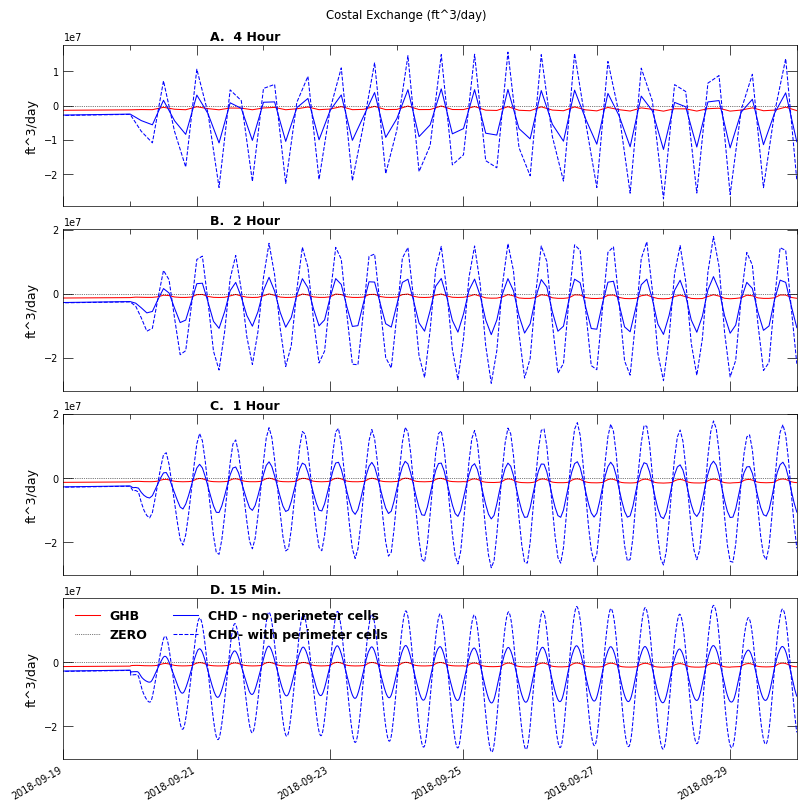

In [21]:
#=================================================================
start_date = pd.Timestamp('2018-09-19 00:00:00')

with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(
        ncols=1,
        nrows=len(labels),
        layout="constrained",
        figsize=(8,8),
        )
    for idx in range(len(sim_dirs)):
        ax = axs[idx]
       # ax.set_ylim(-1 * conversion_factor, 1 * conversion_factor)
        df_ghb = obsdict_GHB[sim_dirs[idx]]["df"]
        df_ghb["ft^3/day"].plot(ax=ax, lw=0.75, ls="-", color='red',sharex=True, label= "GHB")
        df_ghb["ZERO"].plot(ax=ax, lw=0.5, ls=":", color="black", sharex=True)
        
        df_chd = obsdict_CHDsurface_noperim[sim_dirs[idx]]["df"]
        df_chd['ft^3/day'].plot(ax=ax, lw=0.75, ls="-", color='blue', sharex=True, label ="CHD - no perimeter cells")
        #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

        df_chd = obsdict_CHDsurface[sim_dirs[idx]]["df"]
        df_chd['ft^3/day'].plot(ax=ax, lw=0.75, ls="--", color='blue', sharex=True, label ="CHD- with perimeter cells")
        #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

        ax.set_ylabel(f"ft^3/day")
        ax.set_xlabel("")
        ax.set_xlim(start_date, df_ghb.index[-1])
        flopy.plot.styles.heading(ax, idx=idx, heading=labels[idx], x=0.2)

    ax = axs[-1]
    fig.suptitle('Costal Exchange (ft^3/day)')
    leg = flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)


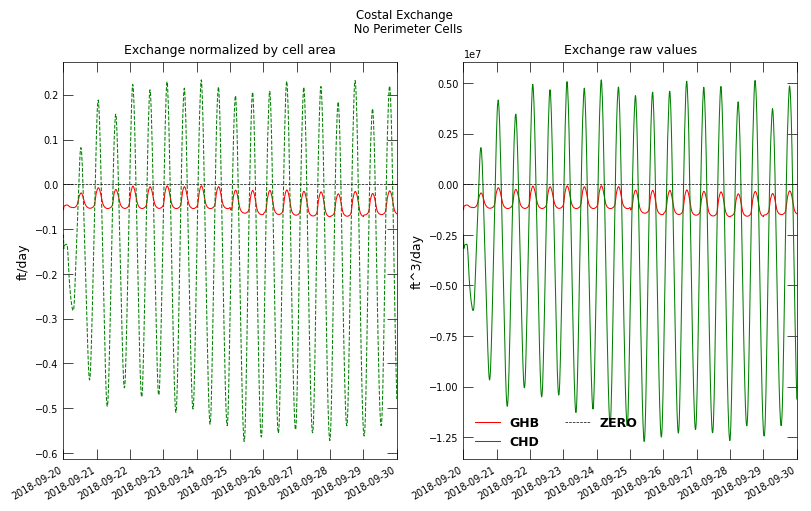

In [22]:
#=================================================================
start_date = pd.Timestamp('2018-09-20 00:00:00')
end_date = pd.Timestamp('2018-09-30 00:00:00')
key = 'run_15.00M'
with flopy.plot.styles.USGSMap():
    fig, ax = plt.subplots(
        layout="constrained",
        nrows=1,
        ncols=2,
        figsize=(8,5)
        )
    # Ft/Day
    #=======
    df_ghb = obsdict_GHB[key]["df"]
    df_ghb["ft/day"].plot(ax=ax[0], lw=0.75, ls="-", color='red',sharex=True, label= "GHB")

    df_chd = obsdict_CHDsurface_noperim[key]["df"]
    df_chd['ft/day'].plot(ax=ax[0], lw=0.75, ls="--", color='green', sharex=True, label ="CHD")
    df_chd["ZERO"].plot(ax=ax[0], lw=0.5, ls="--", color="black", sharex=True)
    ax[0].set_title('Exchange normalized by cell area')
    ax[0].set_ylabel(f"ft/day")
    ax[0].set_xlabel("")
    ax[0].set_xlim(start_date, end_date)



    # FT^3/Day
    #==============
    df_ghb = obsdict_GHB[key]["df"]
    df_ghb["ft^3/day"].plot(ax=ax[1], lw=0.75, ls="-", color='red',sharex=True, label= "GHB")

    df_chd = obsdict_CHDsurface_noperim[key]["df"]
    df_chd['ft^3/day'].plot(ax=ax[1], lw=0.75, ls="-", color='green', sharex=True, label ="CHD")
    df_chd["ZERO"].plot(ax=ax[1], lw=0.5, ls="--", color="black", sharex=True)
    ax[1].set_title('Exchange raw values')
    ax[1].set_ylabel(f"ft^3/day")
    ax[1].set_xlabel("")
    ax[1].set_xlim(start_date, end_date)



    fig.suptitle('Costal Exchange \n No Perimeter Cells')
    leg = flopy.plot.styles.graph_legend(ax=ax[1], loc="lower left", title="none", ncol=2)


### Coastal Exchange Map

#### With Perimeter Cells

In [23]:
# sim = 'run_15.00M'
# datetimes  = "2018-09-29 00:00:00.000000" ,  "2018-09-29 06:00:00.000000"

# for datetime in datetimes:
#     # GHB 
#     # ==========
#     #Populate map with GHB values
#     mg_ghb = mg_gdf.copy()
#     mg_ghb['ghb_flux'] = float(0)
#     #Populate map with GHB values
#     for r,c in zip(obscells_GHB['row'], obscells_GHB['col']):
#         # identify the ghb cell name from the row,col
#         name = obscells_GHB.loc[((obscells_GHB['row'] == r) & (obscells_GHB['col'] == c)), 'ghb_name'].iloc[0]
#         # use the ghb name to correctly index the observation results
#         mg_ghb.loc[((mg_ghb['row_pj'] == r) & (mg_ghb['col_pj'] == c)),'ghb_flux'] = obsdict_GHB[sim]['df'][name.upper()].loc[datetime]

#     #CHD
#     #===========
#     #Populate map with CHD values
#     mg_chd = mg_gdf.copy()
#     mg_chd['chd_flux'] =float(0)
#     for name,r,c in zip(obscells_CHDsurface['chd_name'],obscells_CHDsurface['row'], obscells_CHDsurface['col']):
#         name = name.upper().replace("'","")
#         mg_chd.loc[((mg_chd['row_pj'] == r) & (mg_chd['col_pj'] == c)),'chd_flux'] = obsdict_CHDsurface[sim]['df'][name].loc[datetime]

#     #Figure
#     #---------
#     fig, ax = plt.subplots(1,2, figsize = (10,6))
#     vmin = mg_chd[mg_chd['chd_flux']!=0]['chd_flux'].min()
#     vmax =  mg_chd[mg_chd['chd_flux']!=0]['chd_flux'].max()
#     absmax = max(abs(vmin),abs(vmax))
#     #vmax = 0
#     mg_ghb[mg_ghb['ghb_flux']!=0].plot(column = 'ghb_flux', cmap='seismic_r', vmin=-absmax, vmax=absmax, ax=ax[0], legend_kwds={'shrink': 0.6}) # shrink colorbar to 60% of axis height
#     cx.add_basemap(ax=ax[0], crs=mg_ghb.crs)
#     mg_chd[mg_chd['chd_flux']!=0].plot(column = 'chd_flux', legend=True, cmap='seismic_r', vmin=-absmax, vmax=absmax, ax=ax[1] ,legend_kwds={'shrink': 0.6})  # shrink colorbar to 60% of axis height
#     cx.add_basemap(ax=ax[1], crs=mg_ghb.crs)
#     fig.suptitle(f'Coastal Flux (ft^3/day) \n coupling: {sim} \n{datetime}')
#     fig.tight_layout()   
#     plt.show()

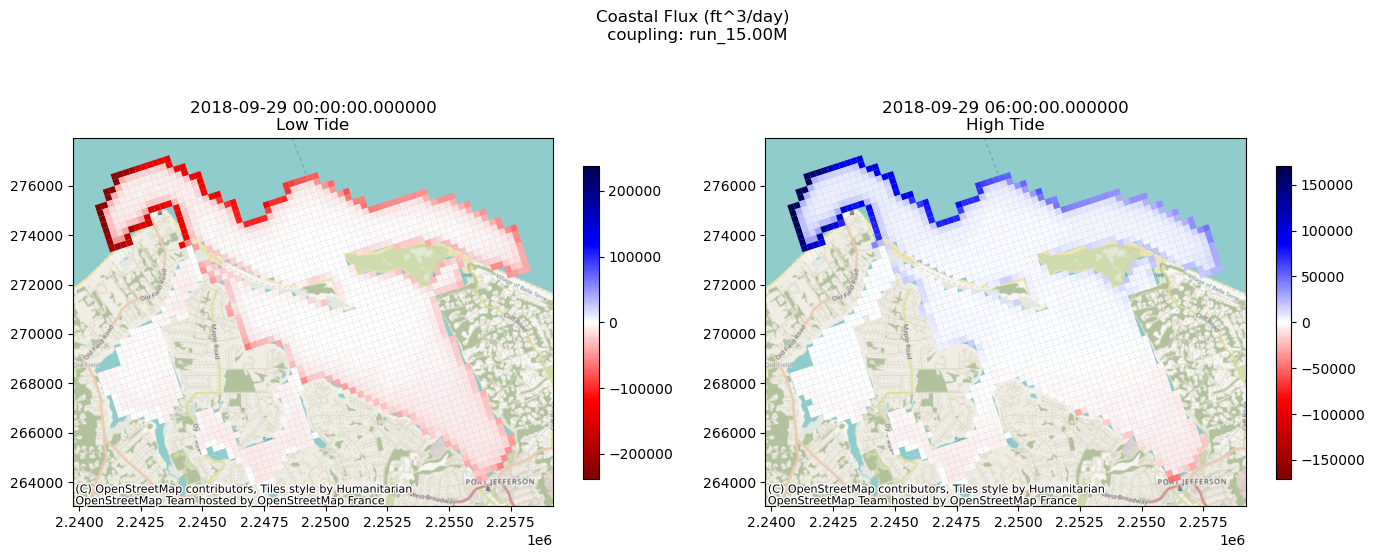

In [24]:
sim = 'run_15.00M'
datetimes  = ("2018-09-29 00:00:00.000000",
    "2018-09-29 06:00:00.000000"
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, datetime in enumerate(datetimes):
    # GHB 
    # ==========
    #Populate map with GHB values
    mg_coastal = mg_gdf.copy()
    mg_coastal['coastal_flux'] = float(0)
 
    #Populate map with GHB values
    for r,c in zip(obscells_GHB['row'], obscells_GHB['col']):
        # identify the ghb cell name from the row,col
        name = obscells_GHB.loc[((obscells_GHB['row'] == r) & (obscells_GHB['col'] == c)), 'ghb_name'].iloc[0]
        # use the ghb name to correctly index the observation results
        mg_coastal.loc[((mg_coastal['row_pj'] == r) & (mg_coastal['col_pj'] == c)),'coastal_flux'] = obsdict_GHB[sim]['df'][name.upper()].loc[datetime]

    for name,r,c in zip(obscells_CHDsurface['chd_name'],obscells_CHDsurface['row'], obscells_CHDsurface['col']):
        name = name.upper().replace("'","")
        mg_coastal.loc[((mg_coastal['row_pj'] == r) & (mg_coastal['col_pj'] == c)),'coastal_flux'] = obsdict_CHDsurface[sim]['df'][name].loc[datetime]

    # Populate Figure
    #---------
    ax = axes[i]
    vmin = mg_coastal[mg_coastal['coastal_flux']!=0]['coastal_flux'].min()
    vmax = mg_coastal[mg_coastal['coastal_flux']!=0]['coastal_flux'].max()
    absmax = max(abs(vmin),abs(vmax))
    mg_coastal[mg_coastal['coastal_flux']!=0].plot(
        column = 'coastal_flux',
        cmap='seismic_r',
        vmin=-absmax,
        vmax=absmax,
        ax=ax,
        legend=True,
        legend_kwds={'shrink': 0.6}
    )
    cx.add_basemap(ax=ax, crs=mg_coastal.crs)
    if datetime =="2018-09-29 00:00:00.000000":
        tide = "Low Tide"
        ax.set_title(f'{datetime}\n{tide}')

    if datetime =="2018-09-29 06:00:00.000000":
        tide = "High Tide"
        ax.set_title(f'{datetime}\n{tide}')

fig.suptitle(f'Coastal Flux (ft^3/day) \n coupling: {sim}')
fig.tight_layout()
plt.show()


#### No Perimeter Cells

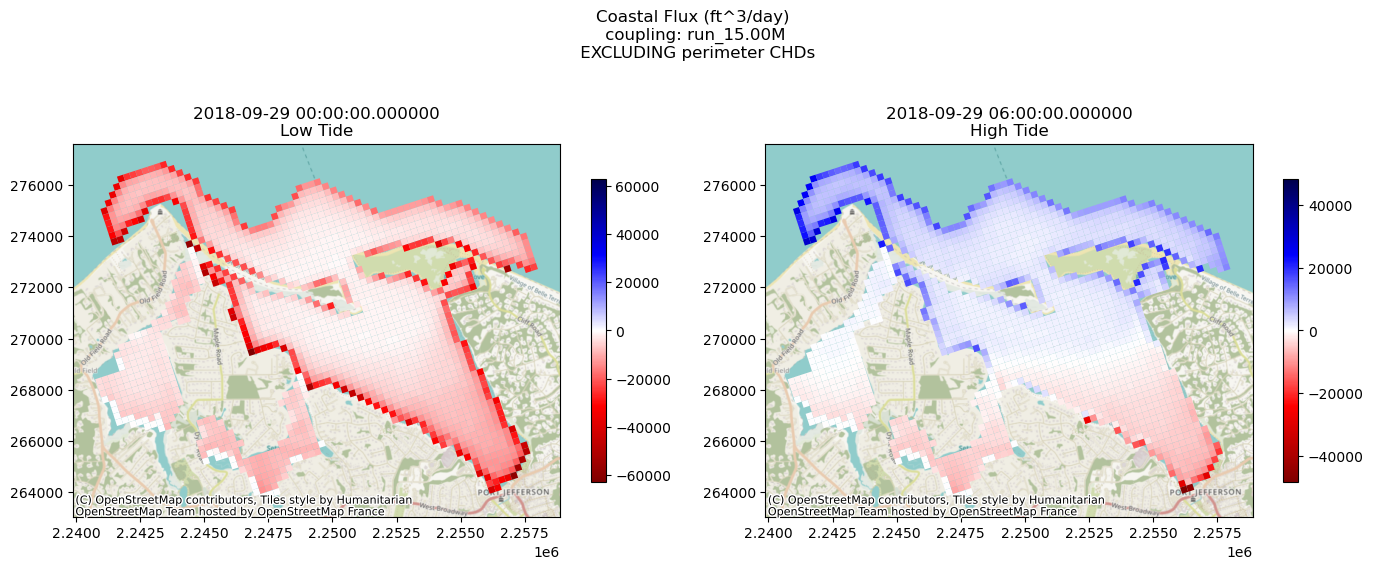

In [25]:
sim = 'run_15.00M'
datetimes  = ("2018-09-29 00:00:00.000000",
    "2018-09-29 06:00:00.000000"
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, datetime in enumerate(datetimes):
    # GHB 
    # ==========
    #Populate map with GHB values
    mg_coastal = mg_gdf.copy()
    mg_coastal['coastal_flux'] = float(0)
 
    #Populate map with GHB values
    for r,c in zip(obscells_GHB['row'], obscells_GHB['col']):
        # identify the ghb cell name from the row,col
        name = obscells_GHB.loc[((obscells_GHB['row'] == r) & (obscells_GHB['col'] == c)), 'ghb_name'].iloc[0]
        # use the ghb name to correctly index the observation results
        mg_coastal.loc[((mg_coastal['row_pj'] == r) & (mg_coastal['col_pj'] == c)),'coastal_flux'] = obsdict_GHB[sim]['df'][name.upper()].loc[datetime]

    for name,r,c in zip(obscells_CHDsurface['chd_name'],obscells_CHDsurface['row'], obscells_CHDsurface['col']):
        if not "perimeter" in name:
            name = name.upper().replace("'","")
            mg_coastal.loc[((mg_coastal['row_pj'] == r) & (mg_coastal['col_pj'] == c)),'coastal_flux'] = obsdict_CHDsurface[sim]['df'][name].loc[datetime]
        # else:
        #     print(fr'{name} not included')

    # Populate Figure
    #---------
    ax = axes[i]
    vmin = mg_coastal[mg_coastal['coastal_flux']!=0]['coastal_flux'].min()
    vmax = mg_coastal[mg_coastal['coastal_flux']!=0]['coastal_flux'].max()
    absmax = max(abs(vmin),abs(vmax))
    mg_coastal[mg_coastal['coastal_flux']!=0].plot(
        column = 'coastal_flux',
        cmap='seismic_r',
        vmin=-absmax,
        vmax=absmax,
        ax=ax,
        legend=True,
        legend_kwds={'shrink': 0.6}
    )
    cx.add_basemap(ax=ax, crs=mg_coastal.crs)
    if datetime =="2018-09-29 00:00:00.000000":
        tide = "Low Tide"
        ax.set_title(f'{datetime}\n{tide}')

    if datetime =="2018-09-29 06:00:00.000000":
        tide = "High Tide"
        ax.set_title(f'{datetime}\n{tide}')

fig.suptitle(f'Coastal Flux (ft^3/day) \n coupling: {sim} \n EXCLUDING perimeter CHDs')
fig.tight_layout()
plt.show()


# Head Observations

In [26]:
# GWF Obs Cells
# #=====================================================
obscells_heads = pd.read_csv(fr"{base_ws}\gwf.obs",skiprows=5, sep=r'  ', names = ['obs_name','head','cellid'])
# Replace *any* whitespace in cellid with commas
obscells_heads['cellid'] = obscells_heads['cellid'].str.replace(r'\s+', ',', regex=True)
# Split into new columns
obscells_heads[['lay', 'row', 'col']] = obscells_heads['cellid'].str.split(',', expand=True)
obscells_heads = obscells_heads.iloc[:-1]
obscells_heads[['lay', 'row', 'col']] = obscells_heads[['lay', 'row', 'col']].astype(int)
obscells_heads[['lay', 'row', 'col']]-=1

# GWF Obs 
#=========
obsdict_head = {}
for sim in sim_dirs:
    obs_path  = fr'{sim_path}{sim}/outputs/hd_obs.csv'
    print(obs_path)
    #df = flopy.utils.Mf6Obs(obs_path).get_dataframe()  
    # Load the GHB observations
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    obsdict_head[sim] = df

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_27892\1461398767.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  obscells_heads = pd.read_csv(fr"{base_ws}\gwf.obs",skiprows=5, sep=r'  ', names = ['obs_name','head','cellid'])


../modflow/pj_2018_adjust_CHDA1/MF+DFlow/run_04.00H/outputs/hd_obs.csv
../modflow/pj_2018_adjust_CHDA1/MF+DFlow/run_02.00H/outputs/hd_obs.csv
../modflow/pj_2018_adjust_CHDA1/MF+DFlow/run_01.00H/outputs/hd_obs.csv
../modflow/pj_2018_adjust_CHDA1/MF+DFlow/run_15.00M/outputs/hd_obs.csv


## Observed vs. Simulated in PJ

In [27]:
pj_network = gpd.read_file("../../../GIS/PJ_mininetwork_2024/PJ_mininetwork_withsensors.shp")
pj_network.to_crs(epsg=4456,inplace=True)
print(pj_network.crs)
# 'screen_top' is the depth to the screen from the casing 
# 'casing_top' is in reference to ft above msl
# calculate 'screen_top_msl' which is in reference to sea-level, by su
pj_network['screen_top_msl'] = pj_network['casing_top']- pj_network['screen_top']
# Determine where the wells intersect the model grid
pj_network_modelcells = gpd.sjoin(mg_gdf,pj_network,how = 'inner', predicate='intersects')

# # MAP OF PJ MONITORING SITES
# # =========================
# fig, ax = plt.subplots(figsize=(5, 5))
# for r,c in zip(obscells_wells['row'], obscells_wells['col']):
#     mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax = ax[0], color = 'r')
# # Plot the points with legend
# pj_network_modelcells.plot(ax=ax)
# pj_network.plot(column='Site',  ax=ax)
# cx.add_basemap(ax, crs=pj_network.crs)
# for idx, row in pj_network.iterrows():
#     x, y = row.geometry.x, row.geometry.y
#     label = row['Site']  # Change to another column if preferred
#     ax.text(x, y, label, fontsize=9, ha='left', va='bottom', color='black')
# plt.show()


# IMPORT AND SAVE PJ WATER LEVEL OBSERVATIONS
# =================================================
from pathlib import Path

lai_dict = {}

# GROUNDWATER
path = Path('../../../PJ_2024WaterLevelNetwork/data/gw')
for file in path.glob('*.csv'):
    f =pd.read_csv(file)
    f['Date/Time'] = pd.to_datetime(f['Date/Time'])
    lai_dict[file.name[:-4]] = f
# SURFACE WATER
path = Path('../../../PJ_2024WaterLevelNetwork/data/sw')
for file in path.glob('*.csv'):
    f =pd.read_csv(file)
    lai_dict[file.name[:-4]] = f
    f['Time'] = pd.to_datetime(f['Time'])


EPSG:4456


Marina OBS_110_L0 0 66 60
ERT-MW-1A: screen top elevation =-35.67, layer=6, layer_val=-26.9
ERT-MW-1B: screen top elevation =-60.62, layer=7, layer_val=-82.23
MillCreek OBS_158_L0 0 69 60
ERT-MW-4B: screen top elevation =-112.21, layer=7, layer_val=-97.2
MW-PD-17: screen top elevation =-55.260000000000005, layer=6, layer_val=-49.37


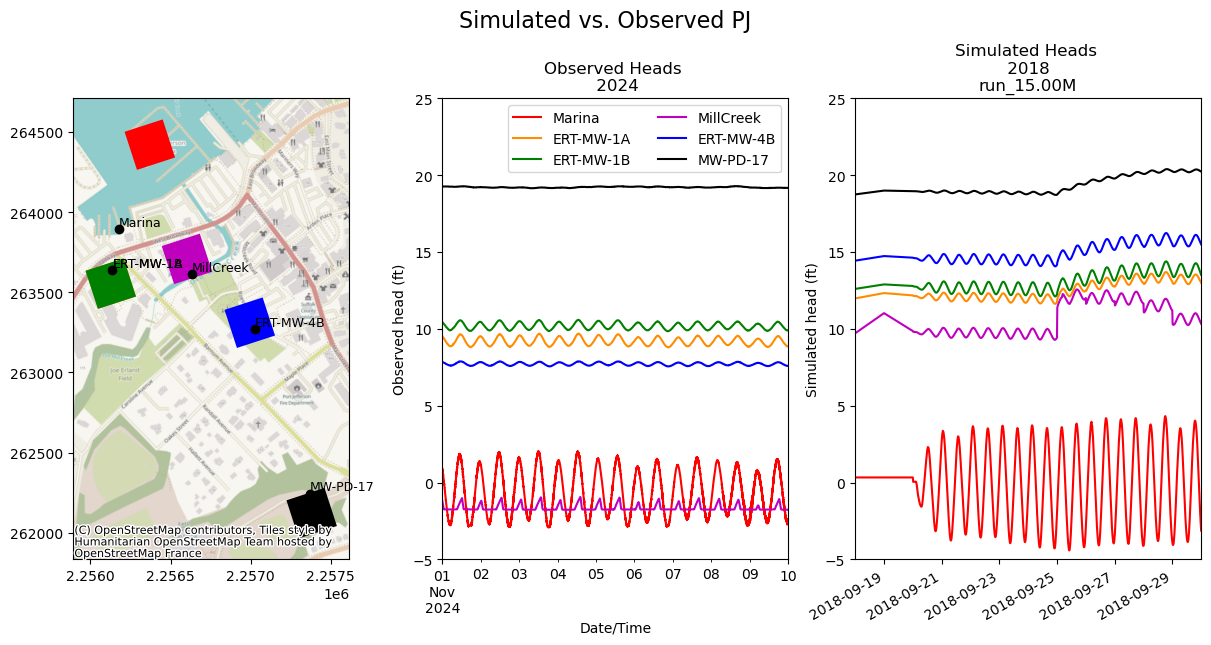

In [28]:
sim = 'run_15.00M'
colors = ['r', 'darkorange', 'g', 'm', 'b', 'k']
start_date = pd.Timestamp('2018-09-18 00:00:00')
fig, ax = plt.subplots(1, 3, figsize=(12, 6), constrained_layout=True)
# Plot site map
#==================
# pj_network_modelcells.plot(ax=ax[0])
# pj_network.plot(column='Site',  ax=ax[0])
# cx.add_basemap(ax=ax[0], crs=pj_network.crs)


for idx, (wellname, screentop, r, c) in enumerate(zip(
        pj_network_modelcells['Site'],
        pj_network_modelcells['screen_top_msl'],
        pj_network_modelcells['row_pj'],
        pj_network_modelcells['col_pj'])):

    if not np.isnan(screentop):
        stack = lay_arr[:, r, c]
        l = (np.abs(stack - screentop)).argmin()
        print(f"{wellname}: screen top elevation ={screentop}, layer={l}, layer_val={stack[l]}")

        obs_name = obscells_heads.loc[
            (obscells_heads['lay'] == l) &
            (obscells_heads['row'] == r) &
            (obscells_heads['col'] == c), 'obs_name'
        ].iloc[0].upper().replace("'", "")


        # Map 
        #pj_network_modelcells.loc[pj_network_modelcells['Site'] == wellname].plot(ax=ax[0], color = colors [idx])
        mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax = ax[0],color = colors[idx])
        pj_network.loc[pj_network['Site'] == wellname].plot(ax=ax[0], color ='k')
        # Observed
        lai_dict[wellname].plot(ax=ax[1], x='Date/Time', y='WLE estimate', label=wellname, color = colors [idx])
        # Simulated
        obsdict_head[sim][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', color = colors [idx])

    else:
        if wellname == 'Marina':
            l, r, c = 0, 66, 60
           # l, r, c = 0, r,c
        if wellname == 'MillCreek':
            l, r, c = 0, r, c
        obs_name = obscells_heads.loc[
            (obscells_heads['lay'] == l) &
            (obscells_heads['row'] == r) &
            (obscells_heads['col'] == c), 'obs_name'
        ].iloc[0].upper().replace("'", "")

        print(wellname,obs_name, l,r,c)
        # Map 
        # pj_network_modelcells.loc[pj_network_modelcells['Site'] == wellname].plot(ax=ax[0], color = colors [idx])
        mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax=ax[0],color = colors[idx])
        pj_network.loc[pj_network['Site'] == wellname].plot(ax=ax[0], color = 'k')
        # Observed
        lai_dict[wellname].plot(ax=ax[1], x='Time', y='elevation', label=wellname, color = colors [idx])
        # Simulated
        obsdict_head[sim][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', color = colors [idx])


for idx, row in pj_network.iterrows():
    x, y = row.geometry.x, row.geometry.y
    label = row['Site']  # Change to another column if preferred
    ax[0].text(x, y, label, fontsize=9, ha='left', va='bottom', color='black')
cx.add_basemap(ax=ax[0], crs=pj_network.crs)

# Styling observed plot
ax[1].legend(ncol = 2)
ax[1].set_xlim('2024-11-1', '2024-11-10')
ax[1].set_ylabel('Observed head (ft)')
ax[1].set_title('Observed Heads \n 2024')
ax[1].set_ylim(-5, 25)


# Styling simulated plot
#ax[2].legend(ncol=1, loc = 'upper left')
ax[2].set_xlim(start_date, df.index[-1])
ax[2].set_ylabel('Simulated head (ft)')
ax[2].set_title(f'Simulated Heads \n 2018 \n{sim}')
ax[2].set_ylim(-5, 25)


# Common title
fig.suptitle('Simulated vs. Observed PJ', fontsize=16, y=1.05)

plt.show()


## Coastal Heads

Text(0.5, 0.98, '(16, 39)\nrun_15.00M')

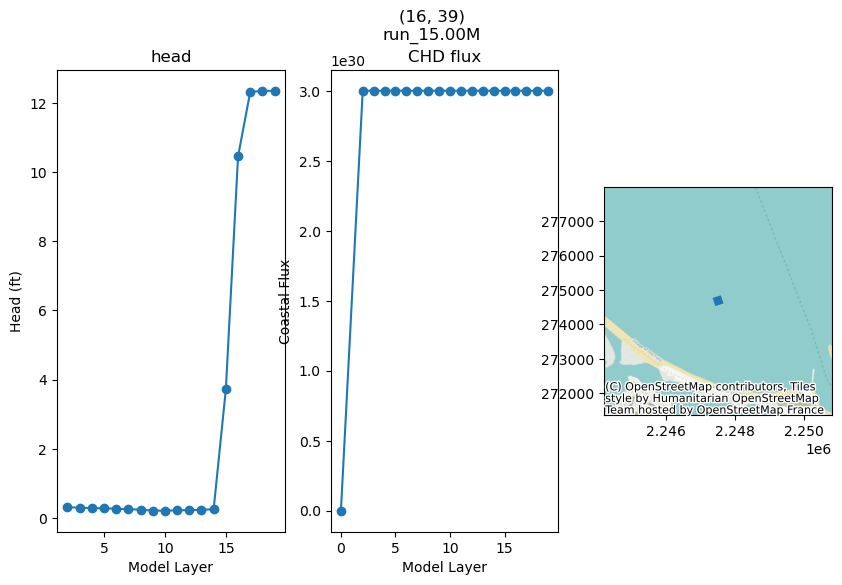

In [30]:
x = []
y = []
x1 = []
y1 = []
sim ='run_15.00M'
datetimes  = "2018-09-29 00:00:00.000000" ,  "2018-09-29 06:00:00.000000"

r = 16
c = 39

fig,ax= plt.subplots(1,3, figsize = (10,6))
name_chd = obscells_CHD.loc[((obscells_CHD['lay'] == 0) & 
                                    (obscells_CHD['row']== r) & 
                                    (obscells_CHD['col'] == c)), 'chd_name'].iloc[0].upper().replace("'", "")
value_chd = obsdict_CHDsurface[sim]["df"][name_chd].loc[datetimes[0]]
#print(value_chd)
x1.append(0)
y1.append(value_chd)

for i in range(2,20):
    l = i
    name = obscells_heads.loc[
        (obscells_heads['lay'] == l) & 
        (obscells_heads['row'] == r) & 
        (obscells_heads['col'] == c),
        'obs_name'
    ].iloc[0].upper().replace("'", "")
    value = obsdict_head[sim][name].loc[datetimes[0]]
    #print(l,r,c,value)
    x.append(i)
    y.append(value)

    name_chd = obscells_CHD.loc[((obscells_CHD['lay'] == l) & 
                                      (obscells_CHD['row']== r) & 
                                      (obscells_CHD['col'] == c)), 'chd_name'].iloc[0].upper().replace("'", "")
    value_chd = obsdict_CHDdepth[sim]["df"][name_chd].loc[datetimes[0]]
    x1.append(i)
    y1.append(value_chd)



ax[0].plot(x, y, marker="o")  
ax[0].set_xlabel('Model Layer')
ax[0].set_ylabel('Head (ft)')
ax[0].set_title('head')
ax[1].plot(x1, y1, marker="o")
ax[1].set_xlabel('Model Layer')
#ax[1].set_yscale('log')
ax[1].set_ylabel('Coastal Flux')
ax[1].set_title('CHD flux')

mg_coastal.loc[((mg_coastal['row_pj'] == r) & (mg_coastal['col_pj'] == c))].plot(ax=ax[2])
ax[2].margins(10)
cx.add_basemap(ax=ax[2], crs = mg_gdf.crs)

fig.suptitle(f'{r,c}\n{sim}')



c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

                         geometry
0  POINT (662172.503 4535164.398) 0 60 60
                         geometry
0  POINT (662342.196 4534900.004) 0 64 61
                         geometry
0  POINT (662270.938 4534634.676) 0 67 59


c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


                         geometry
0  POINT (662343.130 4534659.051) 0 67 60
'0 60 60'
0 60 60
'0 64 61'
0 64 61
'0 67 59'
0 67 59
'0 67 60'
0 67 60


Text(0.5, 0.98, 'Water Levels \n run_15.00M')

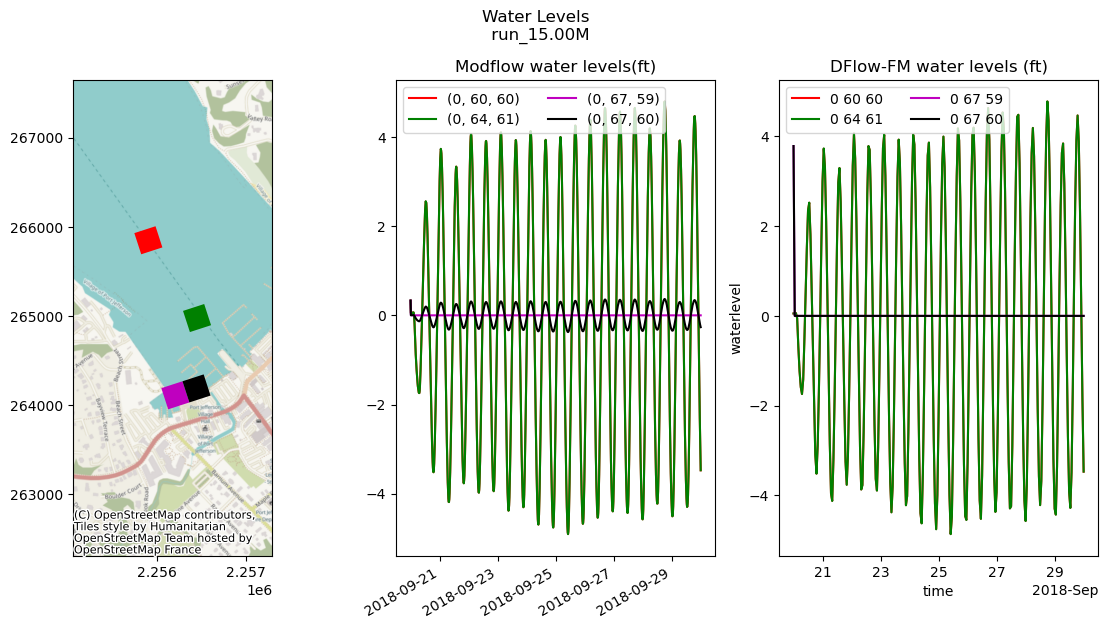

In [31]:
import re
#=================================================================
coords_UTM = []
start_date = pd.to_datetime('2018-09-20')
end_date = pd.to_datetime('2018-09-30')
colors = ['r','g','m','k']

sim = 'run_15.00M'
# CHD head Time Series 
fig, ax = plt.subplots(1, 3, figsize=(14, 7))

for i, (l, r, c) in enumerate([(0, 60, 60), (0, 64, 61), (0, 67, 59), (0, 67, 60)]):
    # assert the cells are CHDs
    assert ((obscells_CHD["lay"] == l) & (obscells_CHD["row"] == r) & (obscells_CHD["col"] == c)).any()

    # get the coordinated of the center of these cells (in UTM) to be used in the DFLOW-FM observation file to ensure that the heads are the same when coupling
    # ----------------------------------------------
    xs = [mg.xcellcenters[r,c]]
    xy = [mg.ycellcenters[r,c]]
    point = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, xy), crs="EPSG:4456")
    point.to_crs(epsg=32618, inplace=True)
    print(point, l,r,c)
    coords_UTM.append(point)


    # plot the map locations
    #-------------------------
    mg_gdf.loc[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(
        ax=ax[0], color=colors[i]
    )

    # Plot the Modflow Head Observations
    #----------------------------------
    # get observation name
    obs_name = obscells_heads.loc[
        (obscells_heads['lay'] == 0) &
        (obscells_heads['row'] == r) &
        (obscells_heads['col'] == c), 
        'obs_name'
    ].iloc[0]
    obs_name = obs_name.upper()
    plot_df  = obsdict_head[sim][obs_name][start_date:end_date]
    # save out for liv
    #plot_df.to_csv(f'tides/tide_{l,r,c}.txt')
    # plot time series
    plot_df.plot(
        x="Time",
        label=f'{l, r, c}',
        ax=ax[1],
        color=colors[i]
    )

# Plot the Dflow water level observations
# ------------------------------------------
ds = xugrid.open_dataset(r"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\dflow-fm\coarse\tides_2018_atm\run\output\FlowFM_his.nc")
# ds = ds.set_xindex("station_name")
station_dict = dict(zip(ds.stations.data, ds.stations['station_name'].data))
# loop through the observations that line up with the mf cell observations
for i,x in enumerate(range(23,27)): 
    station_name = station_dict[x]

    # If it's a byte string, decode to str
    if isinstance(station_name, (bytes, bytearray)):
        station_name = station_name.decode("utf-8", errors="ignore")

    # Strip trailing/leading whitespace
    station_name = station_name.strip()

    print(repr(station_name))  # should now look like '0,60,60'
    print(station_name)
    # convert data to feet
    data = ds.isel(stations=x)['waterlevel'] * 3.28 
    data.plot(ax=ax[2], label = station_name, color = colors[i])
    


# expand map extent by 10% (simple way)
ax[0].margins(0.8)
cx.add_basemap(ax=ax[0], crs=mg_gdf.crs)

# format time series panel
#ax[1].legend(ncol=2,bbox_to_anchor=(0.2, 1),)
ax[1].legend(ncol=2)
ax[1].set_title('Modflow water levels(ft)')

ax[2].set_title('DFlow-FM water levels (ft)')
ax[2].legend(ncol=2)

fig.suptitle(f'Water Levels \n {sim}')
# add basemap


                         geometry
0  POINT (662172.503 4535164.398) 0 60 60
                         geometry
0  POINT (662342.196 4534900.004) 0 64 61
                         geometry
0  POINT (662270.938 4534634.676) 0 67 59
                         geometry
0  POINT (662343.130 4534659.051) 0 67 60
'0 60 60'
0 60 60
'0 64 61'
0 64 61
'0 67 59'
0 67 59
'0 67 60'
0 67 60


c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

Text(0.5, 0.98, 'Water Levels \n run_15.00M')

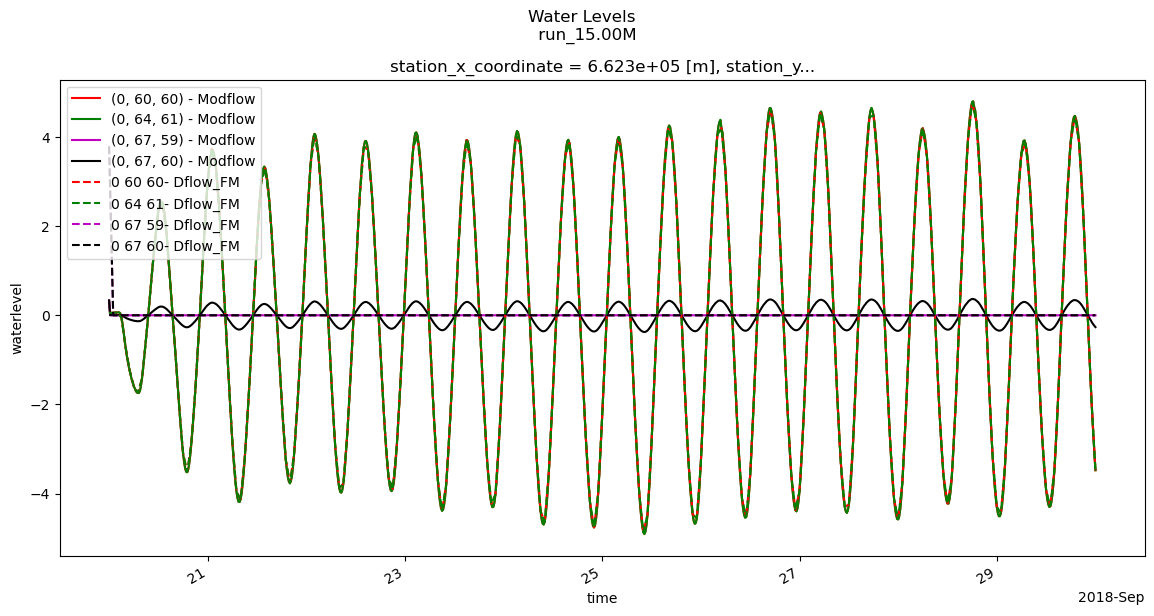

In [32]:
import re
#=================================================================
coords_UTM = []
start_date = pd.to_datetime('2018-09-20')
end_date = pd.to_datetime('2018-09-30')
sim = 'run_15.00M'
colors = ['r','g','m','k']
# CHD head Time Series 
fig, ax = plt.subplots(1, figsize=(14, 7))

for i, (l, r, c) in enumerate([(0, 60, 60), (0, 64, 61), (0, 67, 59), (0, 67, 60)]):
    # assert the cells are CHDs
    assert ((obscells_CHD["lay"] == l) & (obscells_CHD["row"] == r) & (obscells_CHD["col"] == c)).any()

    # get the coordinated of the center of these cells (in UTM) to be used in the DFLOW-FM observation file to ensure that the heads are the same when coupling
    # ----------------------------------------------
    xs = [mg.xcellcenters[r,c]]
    xy = [mg.ycellcenters[r,c]]
    point = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, xy), crs="EPSG:4456")
    point.to_crs(epsg=32618, inplace=True)
    print(point, l,r,c)
    coords_UTM.append(point)

    # Plot the Modflow Head Observations
    #----------------------------------
    # get observation name
    obs_name = obscells_heads.loc[
        (obscells_heads['lay'] == 0) &
        (obscells_heads['row'] == r) &
        (obscells_heads['col'] == c), 
        'obs_name'
    ].iloc[0]
    obs_name = obs_name.upper()
    plot_df  = obsdict_head[sim][obs_name][start_date:end_date]
    # save out for liv
    #plot_df.to_csv(f'tides/tide_{l,r,c}.txt')
    # plot time series
    plot_df.plot(
        x="Time",
        label=f'{l, r, c} - Modflow',
        ax=ax,
        color=colors[i]
    )
ax.legend()

# Plot the Dflow water level observations
# ------------------------------------------
ds = xugrid.open_dataset(r"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\dflow-fm\coarse\tides_2018_atm\run\output\FlowFM_his.nc")
# ds = ds.set_xindex("station_name")
station_dict = dict(zip(ds.stations.data, ds.stations['station_name'].data))
# loop through the observations that line up with the mf cell observations
for i,x in enumerate(range(23,27)): 
    station_name = station_dict[x]

    # If it's a byte string, decode to str
    if isinstance(station_name, (bytes, bytearray)):
        station_name = station_name.decode("utf-8", errors="ignore")

    # Strip trailing/leading whitespace
    station_name = station_name.strip()

    print(repr(station_name))  # should now look like '0,60,60'
    print(station_name)
    # convert data to feet
    data = ds.isel(stations=x)['waterlevel'] * 3.28 
    data.plot(ax=ax, label = f'{station_name}- Dflow_FM', color = colors[i], linestyle = '--')
ax.legend()
fig.suptitle(f'Water Levels \n {sim}')
# add basemap


## Head Contours


## Time Series

coastal heads : dflow versions

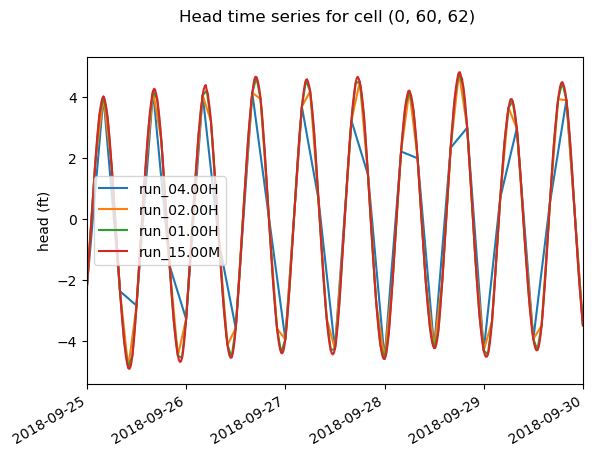

In [33]:
sim_dict_headobs = {}

l,r,c = 0,60,62
obs_name = obscells_heads.loc[((obscells_heads['lay'] == l) & (obscells_heads['row'] == r) & (obscells_heads['col'] == c)), 'obs_name'].iloc[0]
obs_name =obs_name.upper()
obs_name

start_date = pd.Timestamp('2018-09-25 00:00:00')

fig,ax = plt.subplots()
for sim in sim_dirs:
    #Plot Figure
    obsdict_head[sim][obs_name].plot(x = "Time",ax=ax, label = f'{sim}')
ax.legend()
ax.set_xlim(start_date, df.index[-1])
plt.ylabel('head (ft)')
fig.suptitle(f'Head time series for cell {l,r,c}')
plt.show()

# geodataframe of cells to check
cell_location = pd.concat(
    [mg_gdf.loc[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)]])
cell_location.explore(color ="MAGENTA")

## Depth to Water

In [43]:
sim = sim_path + 'run_15.00M'
sim_pj = flopy.mf6.MFSimulation.load(sim_ws=sim)

gwf = sim_pj.get_model("gwf")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ghb...
    loading package drn...
    loading package chd...
    loading package chd...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package wel...
    loading package oc...
    loading package obs...
    loading package buy...
  loading model gwt6...
    loading package dis...
    loading package fmi...
    loading package ssm...
    loading package mst...
    loading package adv...
    loading package ic...
    loading package oc...
  loading exchange package gwf-gwt_exg_0...
  loading solution package gwf...
  loading solution package gwt...


In [50]:

hdobj = gwf.output.head()
heads ={}
head_diff ={}
for i in hdobj.get_kstpkper():
    # Store daily heads
    heads[i] = hdobj.get_data(i)
    heads[i] = np.where(heads[i]==1.e+30 , np.nan, heads[i])

In [82]:
heads.keys()

dict_keys([(2, 0), (0, 31), (0, 59), (0, 90), (0, 120), (0, 151), (0, 181), (0, 212), (0, 242)])

### 2017 Average DTW

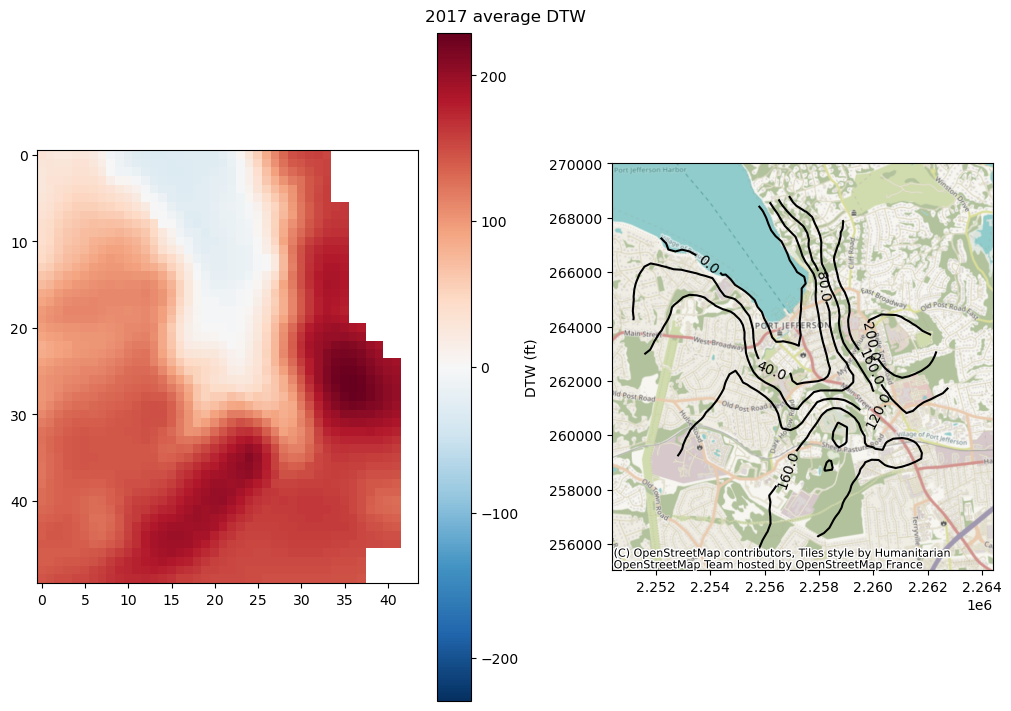

In [81]:
# 2017 average DTW
dtw = lay_arr[0] - heads[2,0]
# layer 1 DTW slice
data = dtw[0][50:100, 40:]
abs_max = np.nanmax(np.abs(data))
vmin = -abs_max
vmax = abs_max

# Larger, spaced figure
fig, ax = plt.subplots(1, 2, figsize=(10, 7), constrained_layout=True)

# --- First subplot: imshow diverging map ---
img = ax[0].imshow(data, vmin=vmin, vmax=vmax, cmap="RdBu_r")
c = plt.colorbar(img, ax=ax[0])
c.set_label("DTW (ft)")

# --- Second subplot: contour plot ---
import cartopy.crs as ccrs
original_crs = ccrs.epsg(4456)

c1 = ax[1].contour(
    mg.xcellcenters[50:100, 40:],
    mg.ycellcenters[50:100, 40:],
    data,
    linewidths=1.5,
    colors="k"
)
ax[1].clabel(c1, inline=True, fontsize=10, fmt='%1.1f')
cx.add_basemap(ax[1], crs=original_crs)
fig.suptitle('2017 average DTW')
plt.show()


# Drain Observations 

In [35]:
# GWF Obs 
#=========
obsdict_drn = {}
obsdict_drnABS = {}
for sim in sim_dirs:
    obs_path  = fr'{sim_path}{sim}\outputs\drn_obs.csv'
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    df_abs = df.abs()

    df = df.merge(mf_tdis_df[['totim','Date']], how= 'left')
    df_abs = df_abs.merge(mf_tdis_df[['totim','Date']], how= 'left')
    
    obsdict_drn[sim] = df
    obsdict_drnABS[sim] = df_abs
# uncoupled drain observations
obs_path = r"D:\LISS_GW\GW_Models\LISUS_conditionedmodels_BNB\2018\conditioned_model_2018_daily\_mfsetup\models\pj_2018_adjust_FINAL\outputs\drn_obs.csv"
df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
df_abs = df.abs()
df = df.merge(mf_tdis_df[['totim','Date']], how= 'left')
df_abs = df_abs.merge(mf_tdis_df[['totim','Date']], how= 'left')
obsdict_drn['uncoupled'] = df
obsdict_drnABS['uncoupled'] = df_abs

# Info about Mill Creek drain observations
obscells_DRN =  pd.read_csv(fr'{sim_path}{sim}\gwf.drn.obs',skiprows=5, sep=r'  ', names = ['drn_name','head','cellid'])
obscells_DRN['cellid'] = obscells_DRN['cellid'].str.replace(r'\s+', ',', regex=True)
obscells_DRN[['lay', 'row', 'col']] = obscells_DRN['cellid'].str.split(',', expand=True)
obscells_DRN = obscells_DRN.iloc[:-1]
obscells_DRN[['lay', 'row', 'col']] = obscells_DRN[['lay', 'row', 'col']].astype(int)
obscells_DRN[['lay', 'row', 'col']]-=1

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_27892\2163164848.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  obscells_DRN =  pd.read_csv(fr'{sim_path}{sim}\gwf.drn.obs',skiprows=5, sep=r'  ', names = ['drn_name','head','cellid'])


In [36]:
millcreek_cells =  mg_gdf.copy().merge(obscells_DRN, left_on=['row_pj','col_pj'],right_on = ['row', 'col'] )
millcreek_cells

,geometry,row_pj,col_pj,drn_name,head,cellid,lay,row,col
0,"POLYGON ((2256444.608 263788.961, 2256521.862 ...",69,60,millcreek1,drn,"1,70,61",0,69,60
1,"POLYGON ((2256682.372 263866.215, 2256759.626 ...",69,61,millcreek0,drn,"1,70,62",0,69,61
2,"POLYGON ((2256284.098 263473.942, 2256361.352 ...",70,59,millcreek2,drn,"1,71,60",0,70,59
3,"POLYGON ((2255885.824 263081.669, 2255963.078 ...",71,57,millcreek4,drn,"1,72,58",0,71,57
4,"POLYGON ((2256123.588 263158.924, 2256200.842 ...",71,58,millcreek3,drn,"1,72,59",0,71,58
5,"POLYGON ((2255725.314 262766.651, 2255802.568 ...",72,56,millcreek5,drn,"1,73,57",0,72,56
6,"POLYGON ((2255327.040 262374.378, 2255404.294 ...",73,54,millcreek7,drn,"1,74,55",0,73,54
7,"POLYGON ((2255564.804 262451.633, 2255642.058 ...",73,55,millcreek6,drn,"1,74,56",0,73,55


In [37]:
# Mill Creek Shapefile
millcreek = gpd.read_file(r"D:\LISS_GW\GW_Models\LISUS_conditionedmodels_BNB\2018\conditioned_model_2018_daily\_mfsetup\GIS\Creek_updated\Creek_BNB.shp")
millcreek.to_crs(epsg=4456, inplace=True)  # Update this line to assign the result to 'millcreek'


624.0 637.0


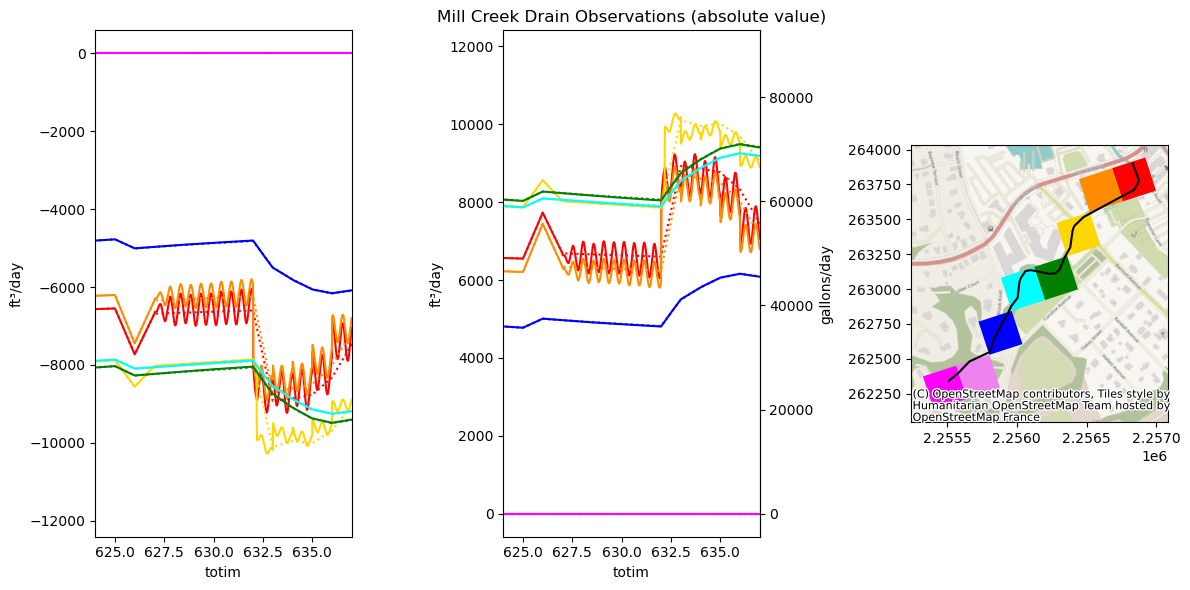

In [38]:
date_ll = '2018-09-16'
date_ul = '2018-09-29'
totim_ll = mf_tdis_df.loc[mf_tdis_df['Date']== date_ll, 'totim'].iloc[0]
totim_ul = mf_tdis_df.loc[mf_tdis_df['Date']== date_ul, 'totim'].iloc[0]
print(totim_ll, totim_ul)


colors = ['red', 'darkorange', 'gold', 'green', 'cyan', 'blue', 'violet', 'magenta']
fig, axes = plt.subplots(1,3, figsize = (12,6)) 
for i in range(0, 8):
    obsdict_drn['run_15.00M'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[0], color = colors[i], legend= False)
    obsdict_drnABS['run_15.00M'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[1], color = colors[i], legend= False)    

    obsdict_drn['uncoupled'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[0], linestyle = ':', color = colors[i], legend= False)
    obsdict_drnABS['uncoupled'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[1], linestyle = ':', color = colors[i], legend= False,label = f'uncloupled_MillCreek{i}')

    millcreek_cells.loc[millcreek_cells['drn_name'] == f'millcreek{i}'].plot(color = colors[i], ax=axes[2])


axes[0].set_xlim(totim_ll,totim_ul)
axes[0].set_ylabel('ft³/day')
axes[1].set_xlim(totim_ll,totim_ul)
axes[1].set_ylabel('ft³/day')
axes[1].set_title('Mill Creek Drain Observations (absolute value)')
# Define conversion functions
def ft3_to_gal(x):
    return x * 7.48052

def gal_to_ft3(x):
    return x / 7.48052
# Add secondary y-axis to right side
axes[1].secondary_yaxis('right', functions=(ft3_to_gal, gal_to_ft3)).set_ylabel('gallons/day')

millcreek.plot(ax=axes[2], color = 'k')
cx.add_basemap(crs = mg_gdf.crs, ax=axes[2])
plt.tight_layout()
plt.show()